In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sys, os, glob, fnmatch
from scipy import optimize
from astropy.io import fits
import pandas as pd

from numpy.polynomial.legendre import legval
from lmfit import models, Parameters, Parameter, Model
from lmfit.models import LinearModel, ConstantModel
from scipy.interpolate import interp1d
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from scipy.special import eval_legendre

from matplotlib.font_manager import FontProperties
font = FontProperties()
font.set_family('serif')
font.set_size('small')

## BOSS ArcLines

We can grab the arclines from the BOSS observations to get a good measurements of the line spreading from the BOSS spectrographs. When we can constrain the shape of the arcline, we can apply this to the sky lines and remove them from the continuum.

In [2]:
#Get Arc files
ARC_DIR = '/Users/parkerf/Desktop/test_data/arcs/'
all_arc_files = glob.glob(ARC_DIR+"/**/*.fits.gz",recursive=True)

In [3]:
blue_arc_files = fnmatch.filter(all_arc_files,"*-b*-*")
red_arc_files = fnmatch.filter(all_arc_files,"*-r*-*")

In [4]:
def eval_tset(fiber_num, tset):
    nx = tset.XMAX - tset.XMIN + 1
    xmid = .5*(tset.XMIN+tset.XMAX)
    x_range = tset.XMAX - tset.XMIN
    xloc = np.linspace(tset.XMIN, tset.XMAX, nx)

    dims = tset.COEFF[0].shape
    xpos = np.tile(xloc,(dims[0],1))
    xpos = xpos % nx

    ypos = np.zeros(xpos.shape)

    xinput = xpos[fiber_num]
    xvec  = 2.0*(xinput-xmid)/x_range

    spectrum = legval(xvec, tset.COEFF[0][fiber_num])
    return spectrum

In [5]:
def extract_data(file, num):
    hdu = fits.open(file)
    flux = hdu[0].data[num]
    sigmas = eval_tset(num, hdu[4].data)
    log_wave = eval_tset(num, hdu[2].data)
    wave = 10**(log_wave)
    arc_lines = hdu[1].data[:,0]
    
    return flux, sigmas, wave, arc_lines

In [6]:
def plot_arc_lines(blue_lines, red_lines):
    bflux, bsigma, bwave, barc_lines = extract_data(blue_arc_files[0],200)
    rflux, rsigma, rwave, rarc_lines = extract_data(red_arc_files[0], 200)
    
    fig, ax = plt.subplots(2,figsize=(12,10))
    ax = ax.flatten()
    
    ax[0].plot(bwave, bflux,'b-')
    xmin, xmax = np.percentile(bwave, (1, 99))
    ymin, ymax = np.percentile(bflux, (1, 100))
    for i, line in enumerate(blue_lines):
            ax[0].text(line, 100000-i*3500, line, rotation=30, fontproperties=font)
    ax[0].set_xlim(xmin, xmax)
    ax[0].set_ylim(ymin, ymax+1000)
    ax[0].set_title("Blue Arc Lines", fontproperties = font)
            
    ax[1].plot(rwave, rflux,'r-')
    xmin, xmax = np.percentile(rwave, (1, 99))
    ymin, ymax = np.percentile(rflux, (1, 100))
    for i, line in enumerate(red_lines):
            ax[1].text(line, 100000-i*3500, line, rotation= 30,fontproperties=font)
    ax[1].set_xlim(xmin, xmax)
    ax[1].set_ylim(ymin, ymax+1000)
    ax[1].set_title("Red Arc Lines", fontproperties = font)


/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.


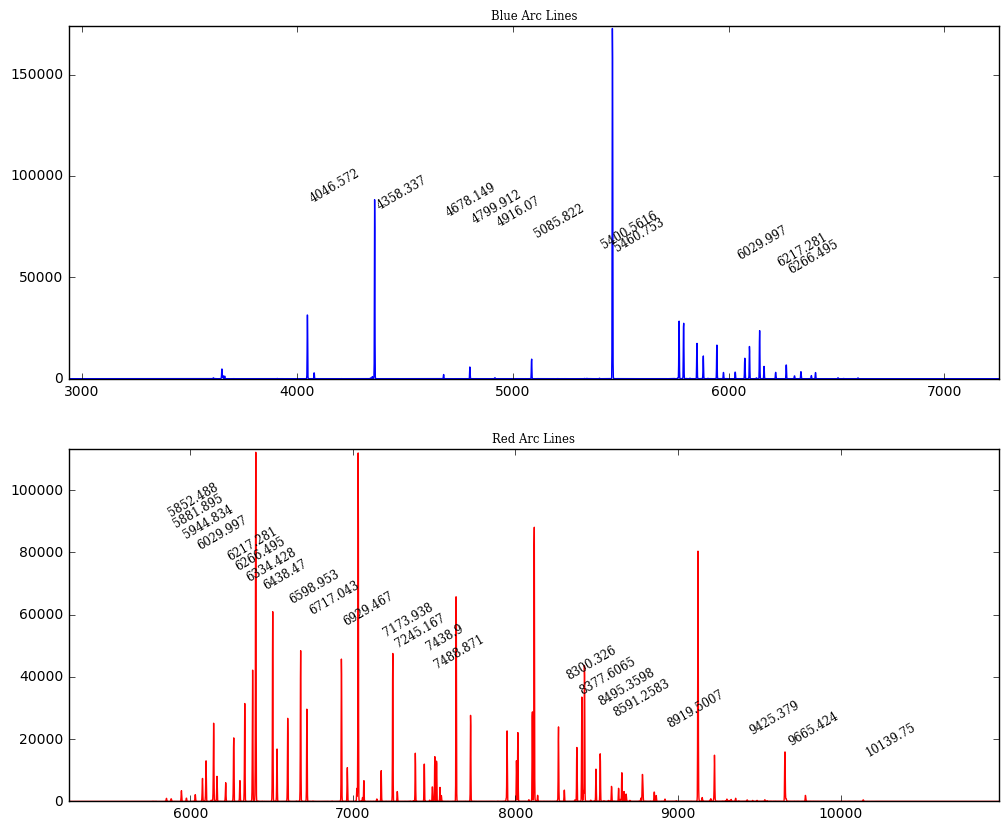

In [7]:
my_blue_lines = np.load('/Users/parkerf/Research/SkyModel/BOSS_Sky/FitTest/files/blue_arc_lines.npy')
my_red_lines = np.load('/Users/parkerf/Research/SkyModel/BOSS_Sky/FitTest/files/red_arc_lines.npy')
plot_arc_lines(my_blue_lines, my_red_lines)

In [8]:
def window_arclines(file, num, line, window_size):
    flux, sigma, wave, arc_lines = extract_data(file, num)
    
    start, stop = [line-window_size, line+window_size]
    section = np.where((wave>start)&(wave<stop))
    window_flux= flux[section]
    window_flux[window_flux<0] = 1e-18
    window_wave = wave[section]
    
    window_weights = error_model(window_flux)
    
    return window_flux, window_wave, window_weights

In [95]:
def error_model(flux):
    sig_sq = flux + 18 + (0.01*flux)**2.
    ww = 1/np.sqrt(sig_sq)
    ww[ww>1e5] = 1/9
    
    return ww

In [10]:
def plot_windowed_lines(file, color, logplot = True):
    if color == 'blue':
        my_lines = my_blue_lines
    elif color == 'red':
        my_lines = my_red_lines
        
    fig, ax = plt.subplots(int(np.ceil(len(my_lines)/2)),2, figsize=(8,15))
    ax = ax.flatten()
    for i, line in enumerate(my_lines):
        flux, wave, weights = window_arclines(file, 200, line, 30)
        if logplot:
            ax[i].semilogy(wave, flux, label = "%d:%.2f"%(i,line))
            ax[i].set_ylim((pow(10,0),pow(10,6)))   
        else:
            ax[i].plot(wave, flux, label = line)
            ax[i].set_ylim((pow(10,0),pow(10,6)))  
        ax[i].legend(prop=font)

In [11]:
bfile = np.random.choice(blue_arc_files, 1)[0]
rfile = np.random.choice(red_arc_files, 1)[0]

/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.


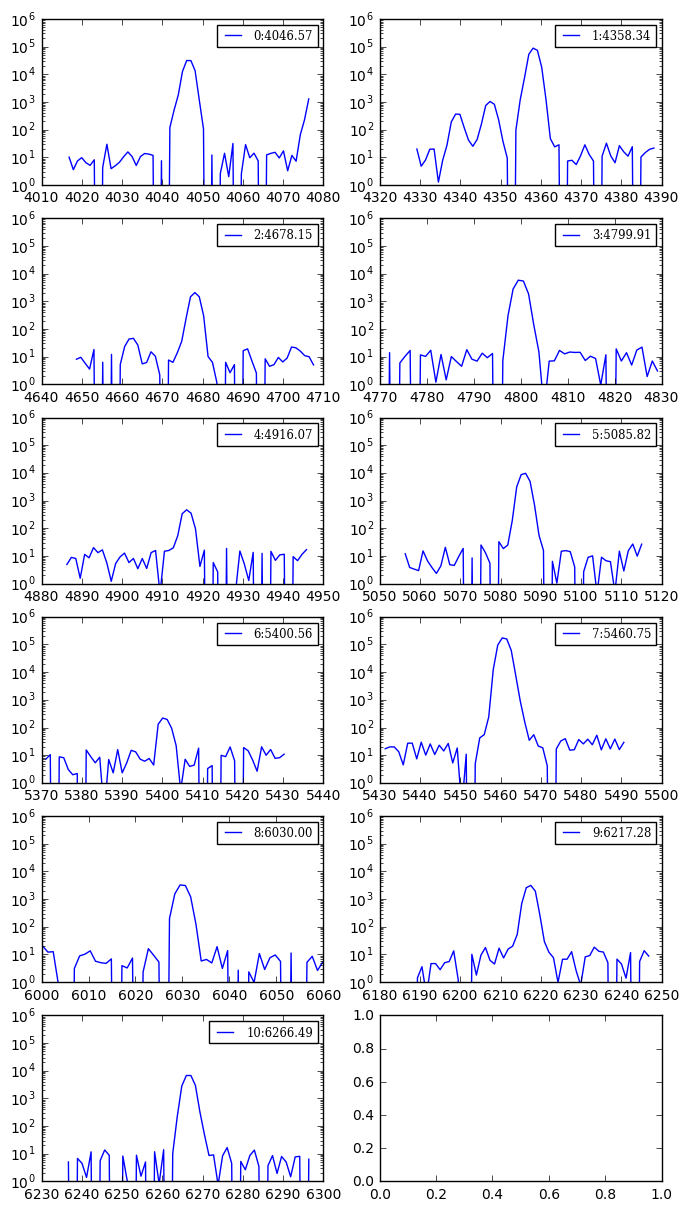

In [12]:
plot_windowed_lines(bfile, 'blue')

/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.


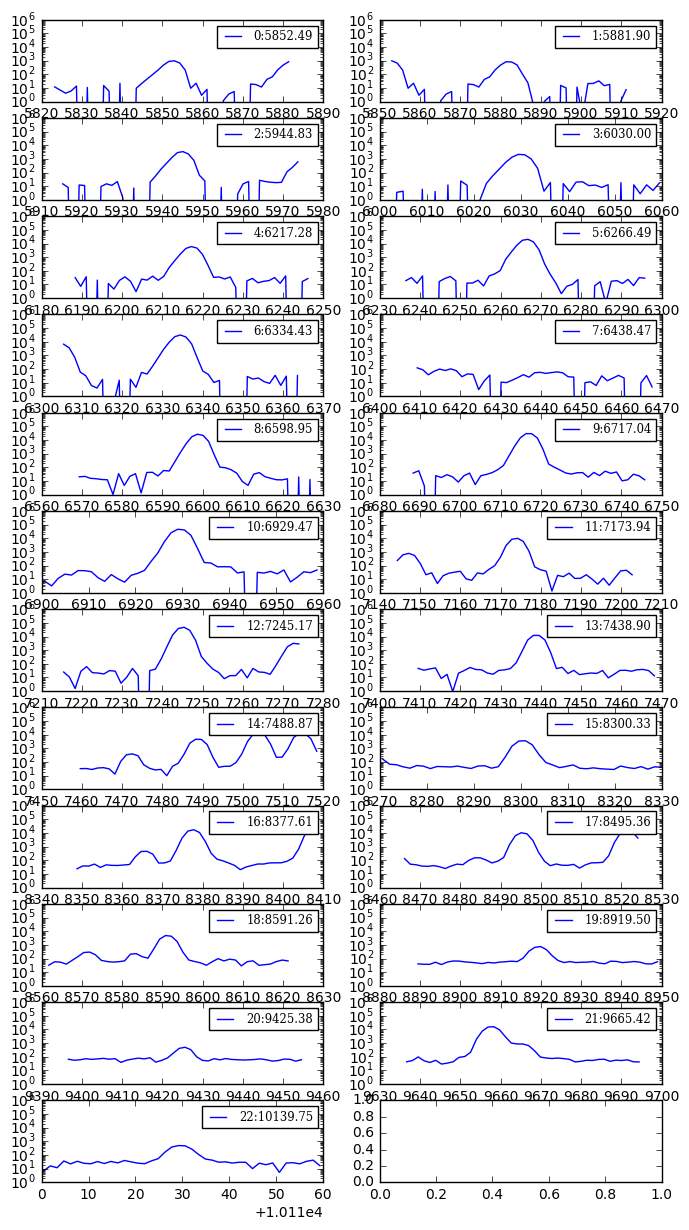

In [13]:
plot_windowed_lines(rfile, 'red')

### How do arclines in the same image differ?

/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.


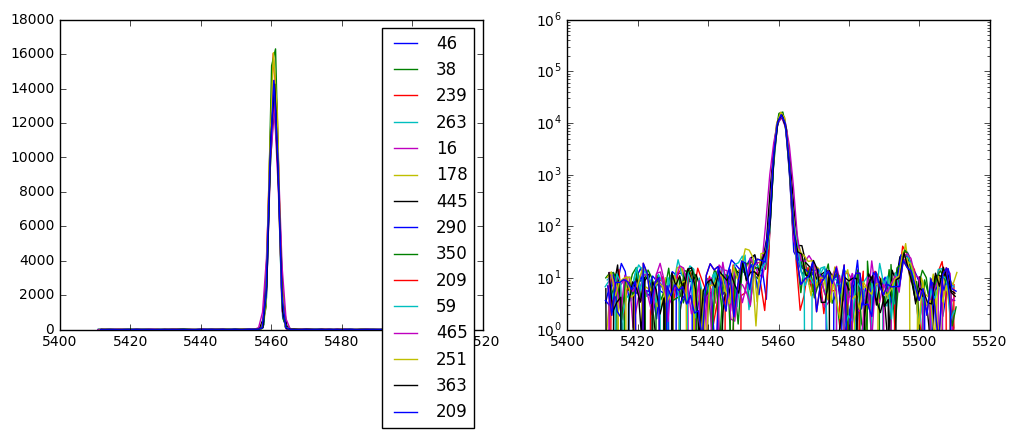

In [14]:
arc_line = my_blue_lines[7]
bfile = np.random.choice(blue_arc_files,1)[0]
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (12,4))
for fiber in np.random.randint(0,high = 500, size = 15):
    flux, wave, weights = window_arclines(bfile, fiber, arc_line, window_size = 50)
    ax1.plot(wave, flux, label = fiber)
    #ax1.set_ylim(150000, 250000)
    #ax1.set_xlim([5440,5480])
    ax2.semilogy(wave, flux, label = fiber)
    ax2.set_ylim(pow(10,0), pow(10,6))
ax1.legend()

## Fitting Arc Lines

The arcline shape is impacted by the spot size on the detector. We expect it to have the following characteristics:
* Slightly change as function of wavelength and location on detector (fiber number) 
* Since spot size is shape of fiber (top hat) convolved wiht gaussian, this should look like two gaussians.
* Expect scatter from grating to correspond to a lorentzian shape and not change from line to line. Therefore we should be able to fix the lorentzian wings for all arclines
* Should have no background. (Note: seem to have some level of background, ~ 18 electrons)

### Is a Gaussian good enough?

In [15]:
def only_gaussian(line, flux, wave, weights, use_c = True):
    model_name = 'gauss'

    g = models.GaussianModel()
    params = g.guess(flux, x = wave)
    
    if use_c:
        c = models.ConstantModel()
        mod = g + c
        params.add('c', value= 18, min = 0)
    else: 
        mod = g

    model = mod.fit(flux, params, x=wave, weights=weights)
    return model

/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.


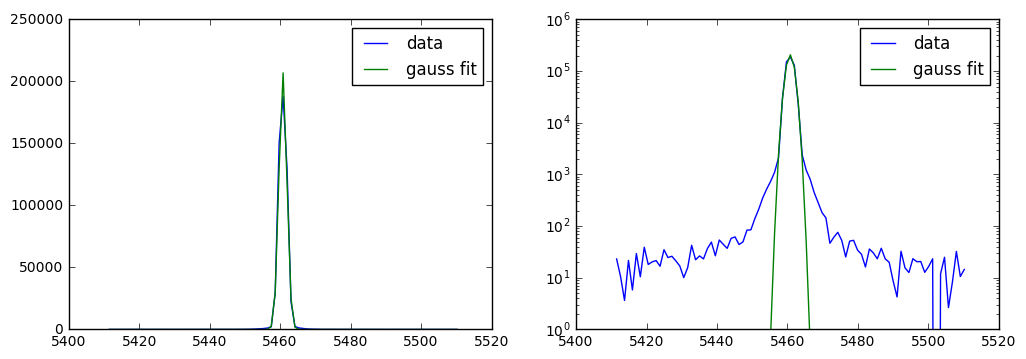

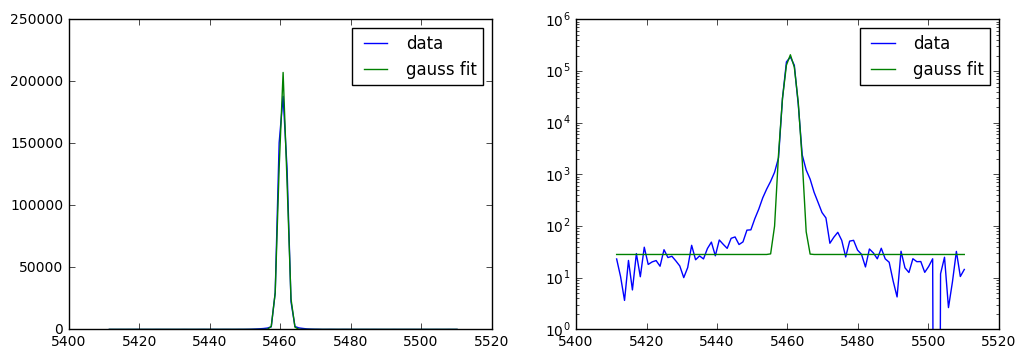

In [16]:
arc_line = my_blue_lines[7]
bfile = blue_arc_files[10]
flux, wave, weights = window_arclines(bfile, 250, arc_line, 50)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(wave, flux, label = 'data')
ax1.plot(wave, only_gaussian(arc_line, flux, wave, weights, use_c = False).best_fit, label = 'gauss fit')
ax2.semilogy(wave, flux, label = 'data')
ax2.semilogy(wave, only_gaussian(arc_line, flux, wave, weights, use_c = False).best_fit, label = 'gauss fit')
ax2.set_ylim(pow(10,0),pow(10,6))
ax1.legend()
ax2.legend()

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(wave, flux, label = 'data')
ax1.plot(wave, only_gaussian(arc_line, flux, wave, weights, use_c = True).best_fit, label = 'gauss fit')
ax2.semilogy(wave, flux, label = 'data')
ax2.semilogy(wave, only_gaussian(arc_line, flux, wave, weights, use_c = True).best_fit, label = 'gauss fit')
ax2.set_ylim(pow(10,0),pow(10,6))
ax1.legend()
ax2.legend()

Gaussian isn't good enough - it doesn't account for the wings and doesn't fit at the peak either. 

### Scattered Light from VPH gratings

In Woords et al, use a Lorentzian to model the scattered light. I this case we convolve it with the gaussian core shape

$Y_{fit} = sinc(b) * \frac{0.5}{N^{2}sin^{2}(a)} + A_{b}$

$b = \pi \frac{\lambda - \lambda_{blaze}}{\lambda_{0}}*f$

$a = \pi \frac{\lambda}{\lambda_{0}}$

In [338]:
# We will use our brightest arcline to develop this model
line = my_blue_lines[7]

In [331]:
bfile = blue_arc_files[15]
flux, wave, weights = window_arclines(bfile, 205, line, 500)

/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.


In [340]:
def my_profile(x, amp1,amp2, a, center, wave1, wave2, sig1, sig2, c):
    N = 83200
    gauss1 = amp1*np.exp(-(x-wave1)**2/(2*sig1**2.))
    gauss2 = amp2*np.exp(-(x-wave2)**2/(2*sig2**2.)) 
    core = gauss1 + gauss2 + c
    
    w = center/N * (1/(np.sqrt(2)*np.pi))
    top = w**2.
    bot = ((x-center)**2+w**2)
    scatt = a*top/bot 
    
    return np.convolve(core, scatt, 'same')

In [128]:
def plot_model_fit(model):
    model.params.pretty_print()
    print('Chi2: ',model.redchi)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
    ax1.plot(wave, flux, label = 'data')
    ax1.plot(wave, model.best_fit, label = 'model')
    ax1.set_xlim(line-5, line+5)
    ax1.set_ylabel("Flux", fontproperties = font)
    ax2.semilogy(wave, flux, label = 'data')
    ax2.semilogy(wave, model.best_fit, label = 'model')
    ax2.set_ylim(pow(10,0),pow(10,6))
    ax2.set_ylabel("Log Flux",fontproperties = font)
    ax1.legend(prop=font)
    ax1.set_xlabel("Wavelength $\AA$", fontproperties = font)
    ax2.set_xlabel("Wavelength $\AA$", fontproperties = font)

5460.753
Name       Value      Min      Max   Stderr     Vary     Expr Brute_Step
a          236.8        0      inf        0     True     None     None
amp1       7.076        0      inf        0     True     None     None
amp2      0.1534        0      inf        0     True     None     None
c          22.27        0      inf        0     True     None     None
center      5460     -inf      inf        0     True     None     None
sig1    0.009998        0      inf        0     True     None     None
sig2     0.05065        0      inf        0     True     None     None
wave1       5458     5458     5461        0     True     None     None
wave2       5462     5461     5464        0     True     None     None
Chi2:  211.47702061


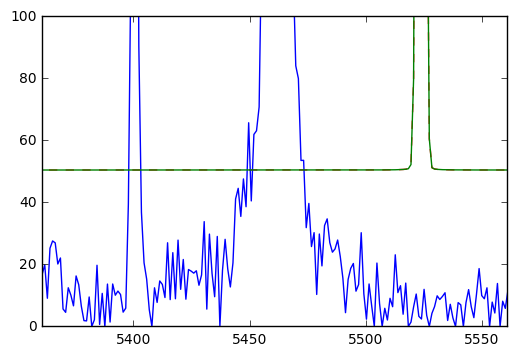

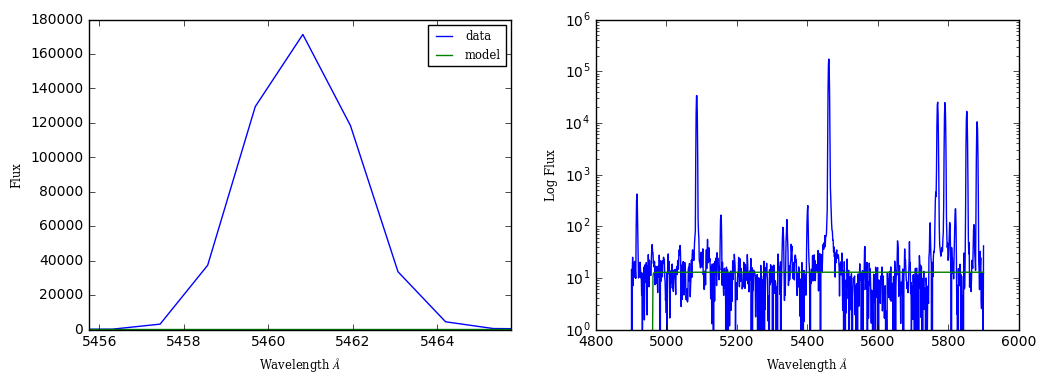

In [341]:
mod = Model(my_profile)
params = mod.make_params()
params.add('amp1', value = 100, min = 0)
params.add('amp2', value = 100, min = 0)
params.add('center', value = line, vary = True)
params.add('wave2', value = line+0.6, min = line, max = line+3)
params.add('wave1', value = line-0.9, min = line-3, max = line)
params.add('a', value = 100, min = 0)
#params.add('N', value = 60000, min = 0, max = 83200)
params.add('sig1', value = 1, min = 0)
params.add('sig2', value = 1, min = 0)
params.add('c', value = 10, min = 0)

model = mod.fit(flux, params, x = wave, weights=weights)
init = mod.eval(params, x=wave)
plt.plot(wave, my_profile(wave, 100,100, 100, line, line+0.6, line-0.9, 1, 1, 10),'r--')
plt.plot(wave, flux)
plt.plot(wave, init)
plt.xlim(line-100, line+100)
plt.ylim(0,100)
print(line)
plot_model_fit(model)

#### This profile (2 gaussians + lorentzian) seems to fit the data quite well. Now need to understand the parameters for the Lorentzian

## 1) Let Everything Vary

### Calculate percentage of flux in wings

In [20]:
def enclosed_energy(wave, model):
    xx = np.linspace(model.params['center'],model.params['center']+7,100)
    f = interp1d(wave, model.best_fit, bounds_error=False, fill_value=0)
    new_flux = f(xx)

    #calculate r
    r = np.abs(model.params['center'] - xx)

    # Calculate amount of flux outside of FWHM
    total_flux = np.sum(new_flux)
    e_e = []
    for i, x in enumerate(xx):
        e_e.append(np.sum(new_flux[0:i])/total_flux)
    m = np.argmin(abs(.95 - np.array(e_e)))
    wings = 1 - np.sum(new_flux[0:m])/total_flux

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
    ax1.axvline(r[m])
    ax1.axhline(1)
    ax1.plot(r, e_e,'o')
    ax1.fill_between(r, e_e, 1, where=r>=r[m], alpha=0.5, facecolor = 'red')

    ax1.set_ylim(0,1.1)
    ax1.set_xlabel('Radius (Ang)', fontproperties = font)
    ax1.set_ylabel('Enclosed Energy', fontproperties = font)
    ax1.set_title("Enclosed Energy in Arc Line %.2f" % model.params['center'], fontproperties = font)
        
    yy = np.linspace(model.params['center']-10,model.params['center']+10,100)
    profile = f(yy)
    ax2.plot(yy, profile)
    ax2.fill_between(yy, profile, 0, where=yy <= model.params['center']-r[m], alpha = 0.5, facecolor = 'red', label = 'wings')
    ax2.fill_between(yy, profile, 0, where=yy >= model.params['center']+r[m], alpha = 0.5, facecolor = 'red')
    #plt.fill_between(yy, profile, 0, where=(yy < model.params['center']+r[m])&(yy > model.params['center']-r[m]), alpha = 0.5, facecolor = 'blue')
    ax2.legend()

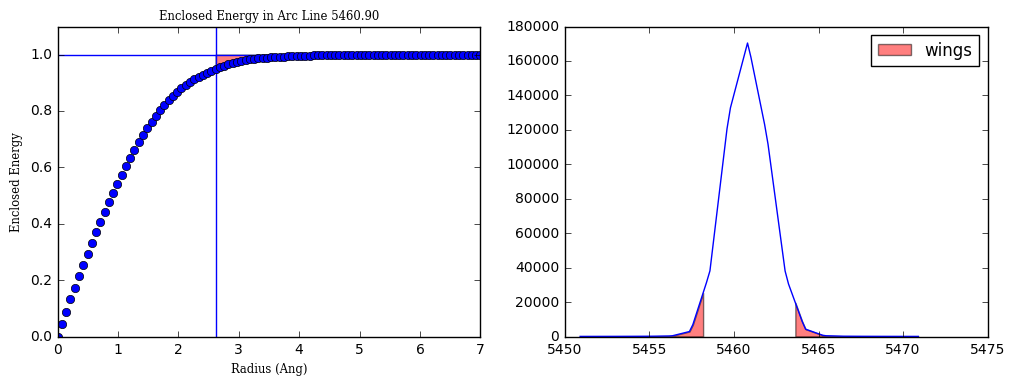

In [21]:
enclosed_energy(wave,model)

## 2) Parameters for scattering function

In [31]:
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter


def chi2_plot(arcline, color):
    if color == 'blue':
        flux, wave, weights = window_arclines(bfile, 205, arcline, 50) 
        max_N = 83200
    elif color == 'red':
        flux, wave, weights = window_arclines(rfile, 205, arcline, 50) 
        max_N = 64000
        
    mod = Model(my_profile)
    params = mod.make_params()
    params.add('amp1', value = 1000, min = 0)
    params.add('amp2', value = 1000, min = 0)
    params.add('center', value = arcline, vary = True)
    params.add('wave2', value = arcline+0.6, min = arcline-3, max = arcline+3)
    params.add('wave1', value = arcline-0.9, min = arcline-3, max = arcline+3)
    params.add('a', value = 1000, min = 0)
    params.add('N', value = 60000, min = 0, max = 83200)
    params.add('sig1', value = 1, min = 0)
    params.add('sig2', value = 1, min = 0)
    params.add('c', value = 10, min = 0)

    pre_model = mod.fit(flux, params, x = wave, weights=weights)

    model_params = []
    for N_eff in np.linspace(10000, max_N, 50):
        for amp in np.linspace(1, 1800, 50):
            mod = Model(my_profile)
            params = mod.make_params()
            params.add('amp1', value = pre_model.params['amp1'], vary=False)
            params.add('amp2', value = pre_model.params['amp2'], vary=False)
            params.add('center', value = pre_model.params['center'], vary=False)
            params.add('wave1', value = pre_model.params['wave1'], vary=False)
            params.add('wave2', value = pre_model.params['wave2'], vary=False)
            params.add('a', value = amp, vary=False)
            params.add('N', value = N_eff, vary=False)
            params.add('sig1', value = pre_model.params['sig1'], vary=False)
            params.add('sig2', value = pre_model.params['sig2'], vary=False)
            params.add('c', value = pre_model.params['c'], vary=False)
            model = mod.fit(flux, params, x = wave, weights=weights)

            model_params.append([model.params['N'].value, model.params['a'].value, model.redchi])
            
    Mp = pd.DataFrame(model_params, columns = ['N','Amp','chi2'])
    Mp = Mp[Mp['chi2']<10]

    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,4))
    
    ax1.semilogy(wave, flux, label = 'data')
    ax1.semilogy(wave, pre_model.best_fit, label = 'fit')
    ax1.legend(prop=font)
    ax1.set_ylim(pow(10,0), pow(10,6))
    ax1.set_title(arcline, fontproperties = font)
    s = ax2.scatter(Mp['N'], Mp['Amp'], c = Mp['chi2'])
    plt.colorbar(s, ax = ax2, cmap = 'jet')
    ax2.set_xlabel("N_eff")
    ax2.set_ylabel("Scatt. Amp")
#     ymin, ymax = np.percentile(Mp['Amp'], (-1, 101))
#     xmin, xmax = np.percentile(Mp['N'], (-1,101))
#     ax2.set_ylim(ymin, ymax)
#     ax2.set_xlim(xmin, xmax)
    ax2.set_title("$\chi^{2}$ map", fontproperties = font)

/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.


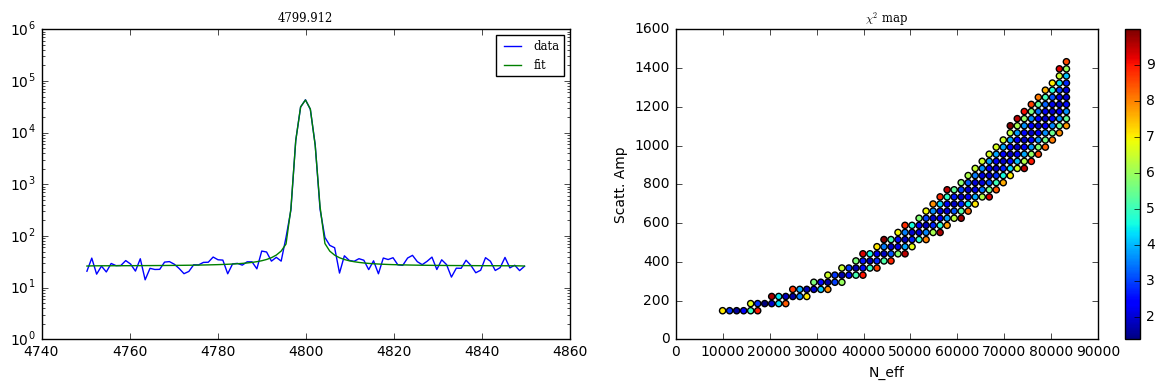

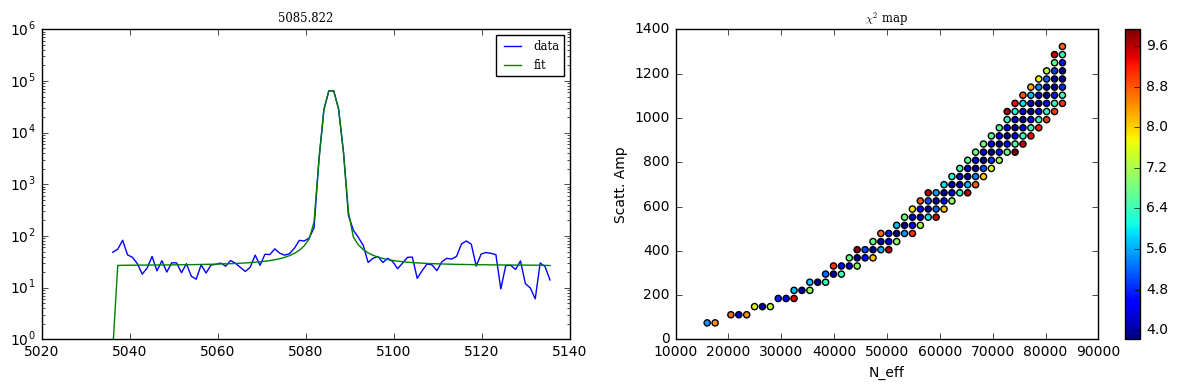

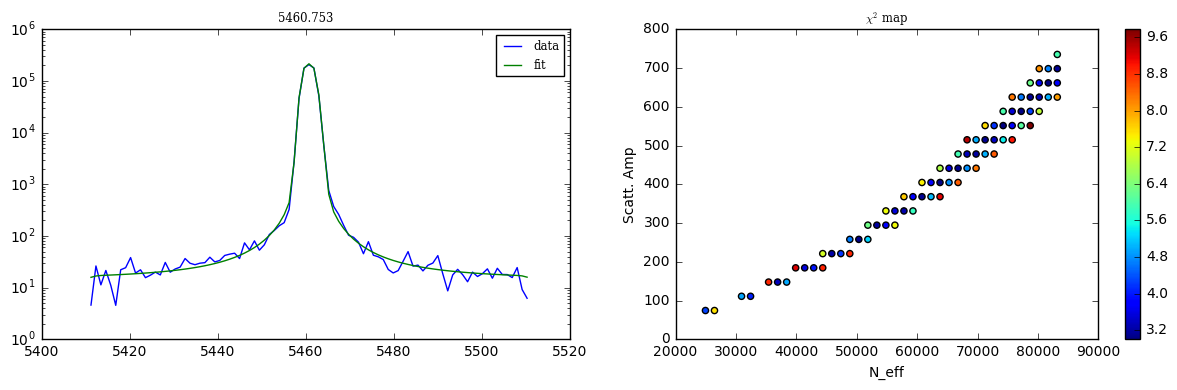

In [24]:
bfile = np.random.choice(blue_arc_files, 1)[0]
for i in [3,5,7]:
    chi2_plot(my_blue_lines[i],'blue')

/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.


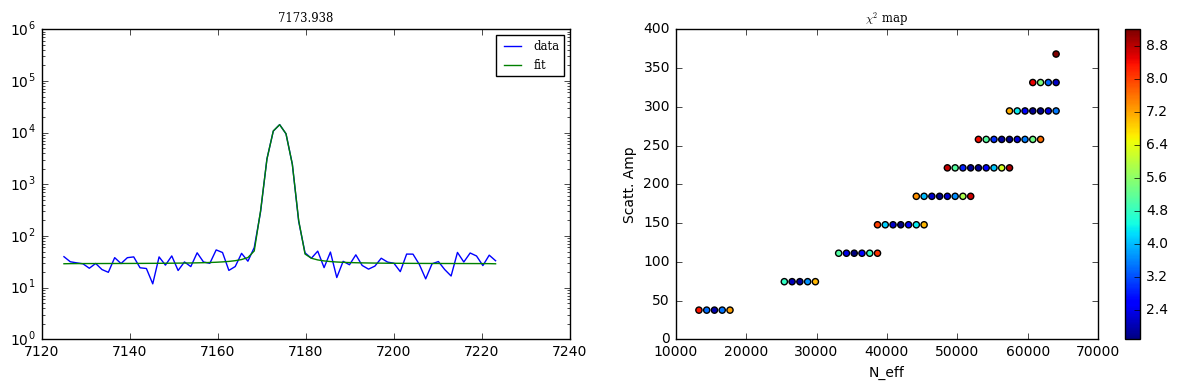

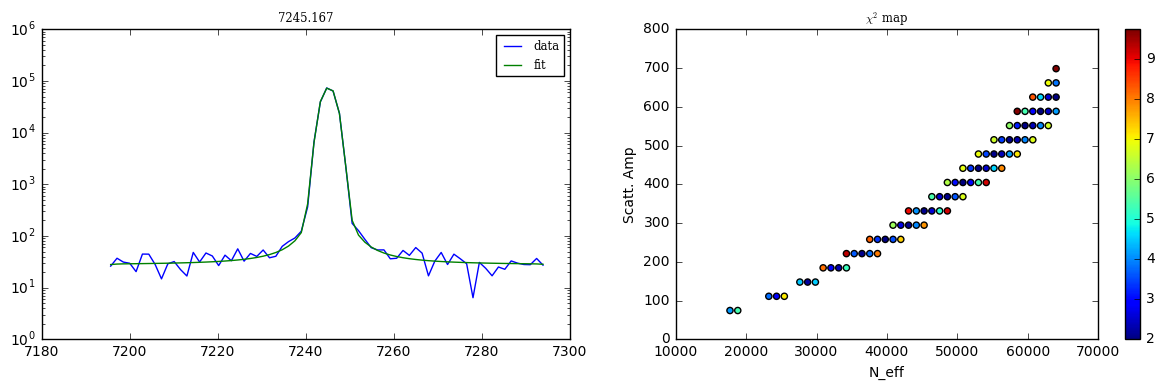

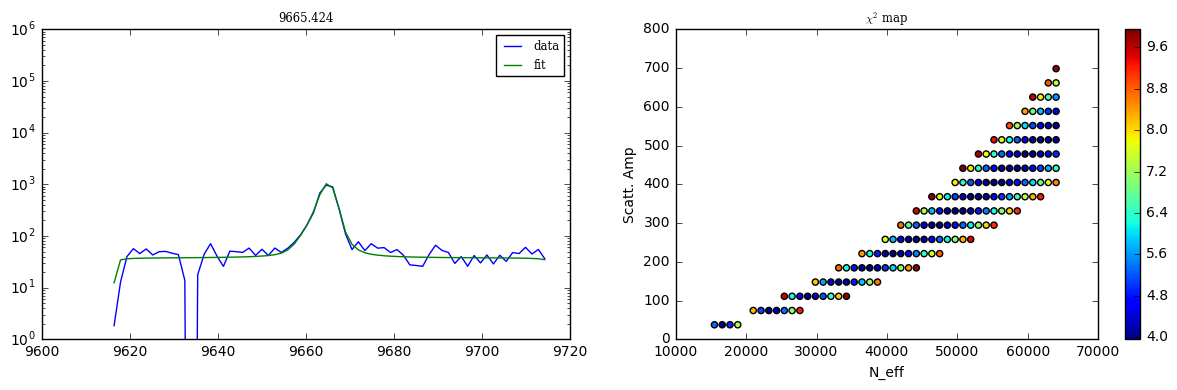

In [34]:
rfile = np.random.choice(red_arc_files, 1)[0]
for i in [11,12,21]:
    chi2_plot(my_red_lines[i],'red')

Now need to look at the amplitude of the scattering function. If we keep N eff at 325 then we should get a best fit based on the above work. The amplitude of the scattering function should then be a function of the total flux or the amplitude of the fitted core

In [35]:
def run_model(line, file, fiber_num, color):
    flux, wave, weights = window_arclines(file, fiber_num, line, 50)
    if color == 'blue':
        N = 83200
    elif color == 'red':
        N = 64000
    
    mod = Model(my_profile)
    params = mod.make_params()
    
    params.add('amp1', value = 1000, min = 0)
    params.add('amp2', value = 1000, min = 0)
    params.add('center', value = line, vary = True)
    params.add('wave1', value = line+1.2, min = line-2,max = line+2, vary=True)
    params.add('wave2', value = line-0.5, min = line-2,max = line+2,vary=True)
    params.add('a', value = 100, min = 0)
    params.add('N', value = N, vary = False)
    params.add('sig1', value = 1, min = 0)
    params.add('sig2', value = 1, min = 0)
    params.add('c', value = 10, min = 0)

    model = mod.fit(flux, params, x = wave, weights=weights)
    total_flux = np.sum(model.best_fit)
    return model, total_flux, line

list_of_params = ['amp1','amp2','center','wave1','wave2','a','N','sig1','sig2','c']

def collect_params(model, total_flux, line):
    p = model.params
     
    features = [model.redchi, total_flux, line]
    for param in list_of_params:
        features.append(p[param].value)
    return features

In [37]:
blue_fit_stats = []
for blue_file in np.random.choice(blue_arc_files,10):
    for fiber_num in np.random.randint(0, 500, 20):
        for i in [3,5,7]:
            l = my_blue_lines[i]
            mod,  tf, line = run_model(l, blue_file, fiber_num,'blue')
            blue_fit_stats.append(collect_params(mod, tf, line))

/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.


In [39]:
red_fit_stats = []
for blue_file in np.random.choice(red_arc_files,10):
    for fiber_num in np.random.randint(0, 500, 20):
        for i in [11,12,21]:
            l = my_red_lines[i]
            mod,  tf, line = run_model(l, blue_file, fiber_num,'red')
            red_fit_stats.append(collect_params(mod, tf, line))

/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.


In [40]:
fit_stats = np.vstack([blue_fit_stats, red_fit_stats])

In [41]:
len(fit_stats)

1200

In [42]:
new_params = ['chi2','total_flux','line']
df1 = pd.DataFrame(fit_stats, columns = new_params+list_of_params)
df1.head()

,chi2,total_flux,line,amp1,amp2,center,wave1,wave2,a,N,sig1,sig2,c
0,1.858541,89551.784363,4799.912,4451.595428,5624.836937,4800.385092,4797.970383,4799.397634,163.515905,83200.0,0.874322,0.943774,4.392821
1,3.466918,140636.760256,5085.822,15885.324587,12524.453863,5085.762973,5086.441428,5084.988978,87.959518,83200.0,1.002395,0.936002,8.732216
2,3.810077,642640.296573,5460.753,5558.628905,19783.150035,5460.422857,5459.211395,5461.049643,452.338431,83200.0,0.727720,1.163500,1.054080
3,1.567369,90211.558140,4799.912,6083.643626,3422.468936,4799.917179,4800.363994,4798.915614,208.183916,83200.0,1.006188,0.822392,3.875356
4,3.997972,142261.601665,5085.822,10615.622710,8634.691502,5086.236390,5085.339817,5083.860387,159.056596,83200.0,0.944072,0.844362,4.933910


In [43]:
df1 = df1[df1['chi2']<10]

(0, 1400)

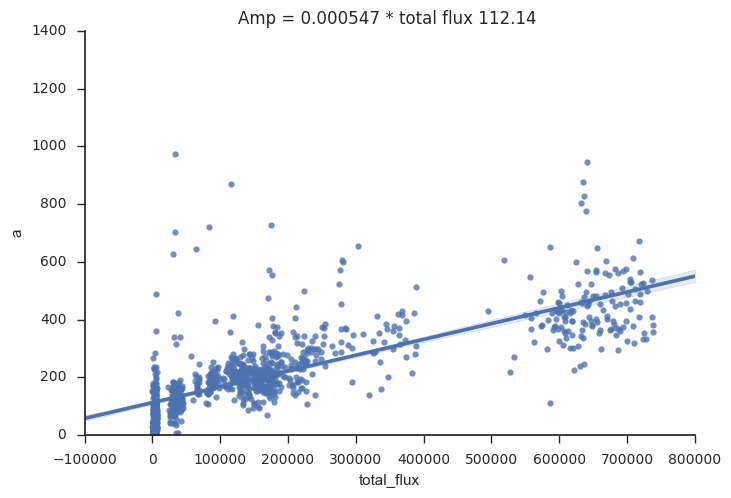

In [45]:
# looks like there is a close linear relationship between the amplitude and total flux
sns.set(style='ticks')
sns.lmplot(x="total_flux", y="a", data=df1,aspect = 1.5)
slope, intercept, r_value, p_value, std_err = stats.linregress(df1['total_flux'], df1['a'])
#plt.plot(df['total_flux'], slope*(df['total_flux'])+intercept, 'r-')
plt.title("Amp = %.6f * total flux %.2f "%(slope, intercept))
plt.ylim(0,1400)

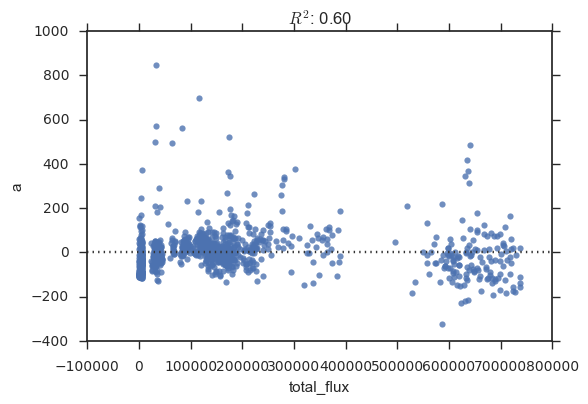

In [46]:
sns.residplot(x="total_flux", y="a",data = df1)
plt.title("$R^{2}$: %.2f" % r_value**2)

(0, 1400)

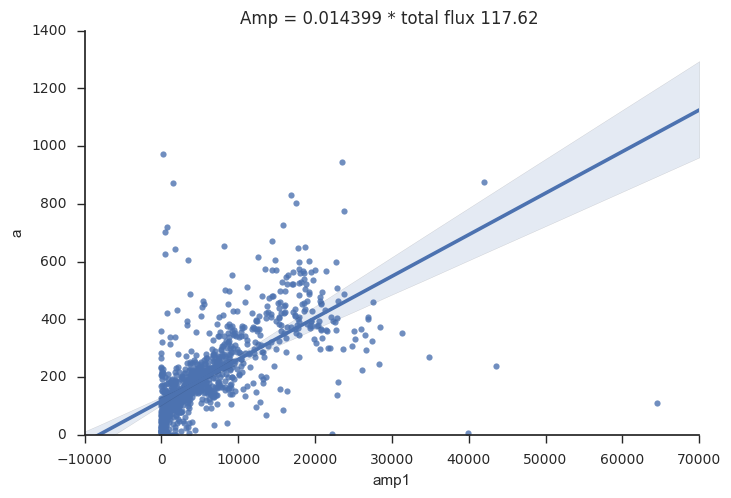

In [112]:
# looks like there is a close linear relationship between the amplitude and total flux
sns.set(style='ticks')
sns.lmplot(x="amp1", y="a", data=df1,aspect = 1.5)
slope, intercept, r_value, p_value, std_err = stats.linregress(df1['amp1'], df1['a'])
#plt.plot(df['total_flux'], slope*(df['total_flux'])+intercept, 'r-')
plt.title("Amp = %.6f * total flux %.2f "%(slope, intercept))
plt.ylim(0,1400)

Is this a good enough fit to use it? What about center wavelength of lorentzian?

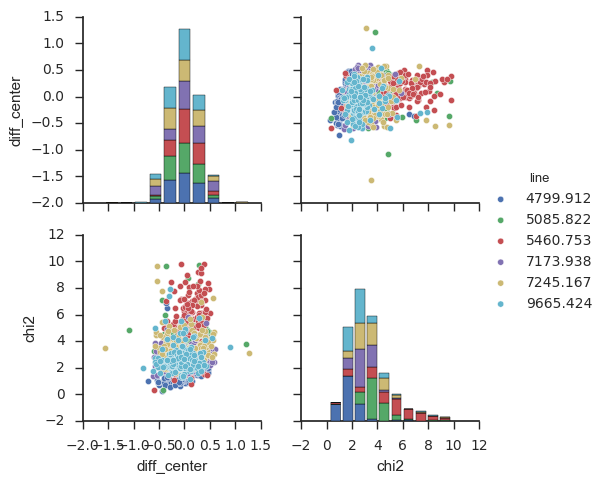

In [51]:
df1['diff_center'] = df1['center'] - df1['line']
sns.pairplot(df1,vars = ['diff_center','chi2'],hue = 'line')

## 3) Core parameters

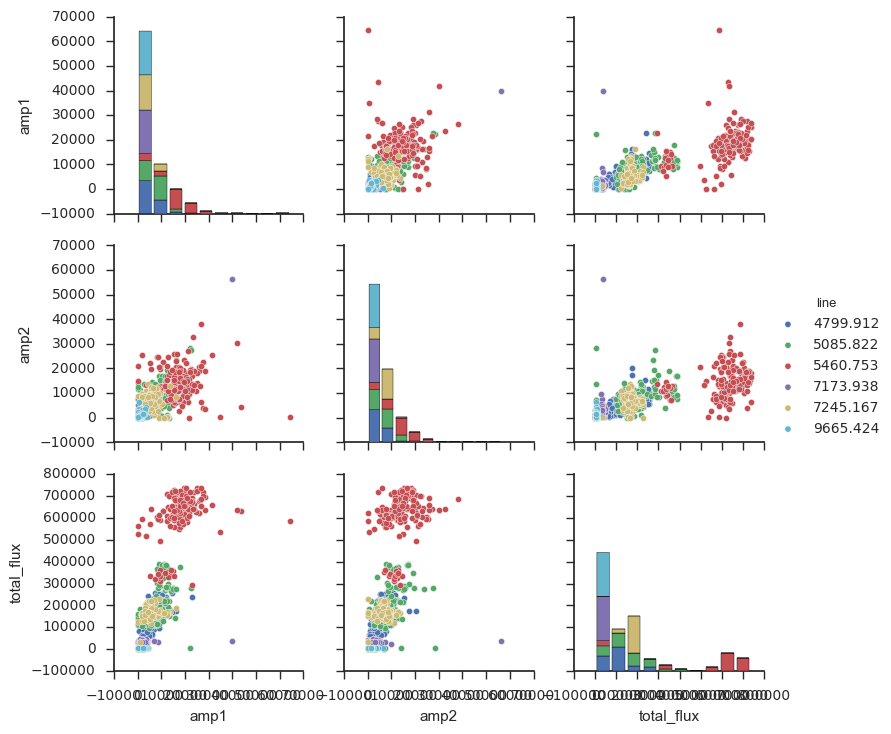

In [56]:
sns.pairplot(df1, vars = ['amp1','amp2','total_flux'],hue='line')

It seems that amp1 and amp2 are switched between being the greater and lesser, for some reason. If I force amp1 to always be the higher, perhaps we can control the relationship better

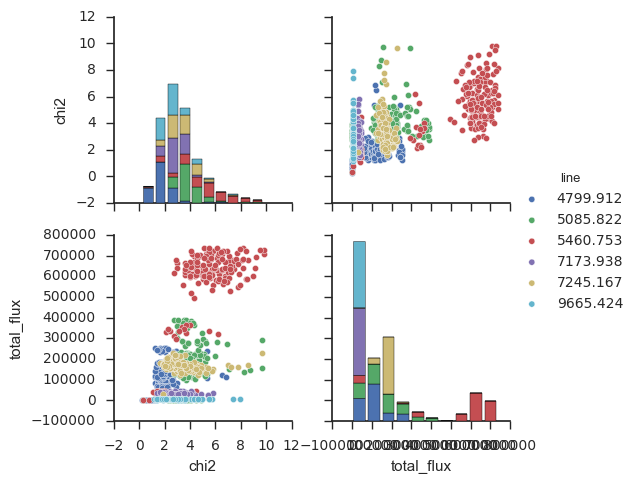

In [53]:
sns.pairplot(df1, vars = ['chi2','total_flux'],hue='line')

Diff 1: 0.20 (1.08)
Diff 2:-0.95 (0.91) 


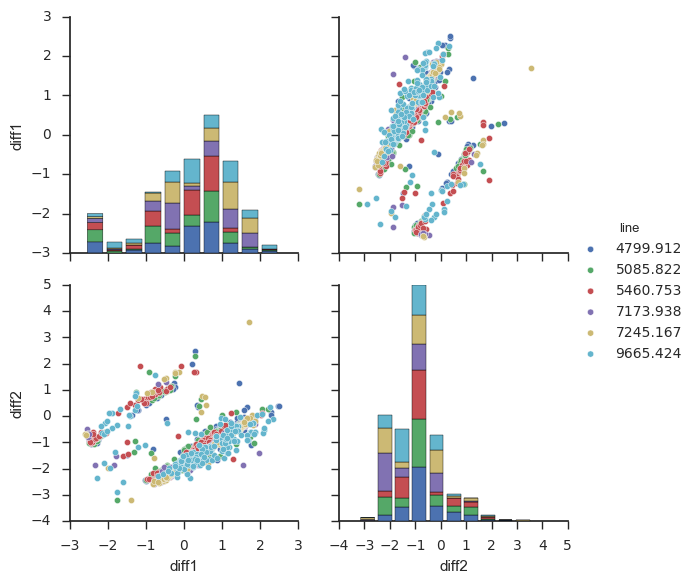

In [55]:
df1['diff1'] = df1['wave1'] - df1['center'] 
df1['diff2'] = df1['wave2'] - df1['center'] 
print("Diff 1: %.2f (%.2f)"%(np.mean(df1['diff1']),np.std(df1['diff1'])))
print("Diff 2:%.2f (%.2f) "%(np.mean(df1['diff2']),np.std(df1['diff2'])))
sns.pairplot(df1, vars = ['diff1','diff2'],size = 3,hue = 'line')

Sig 1: 1.010(0.488)
Sig 2: 1.077(0.453)


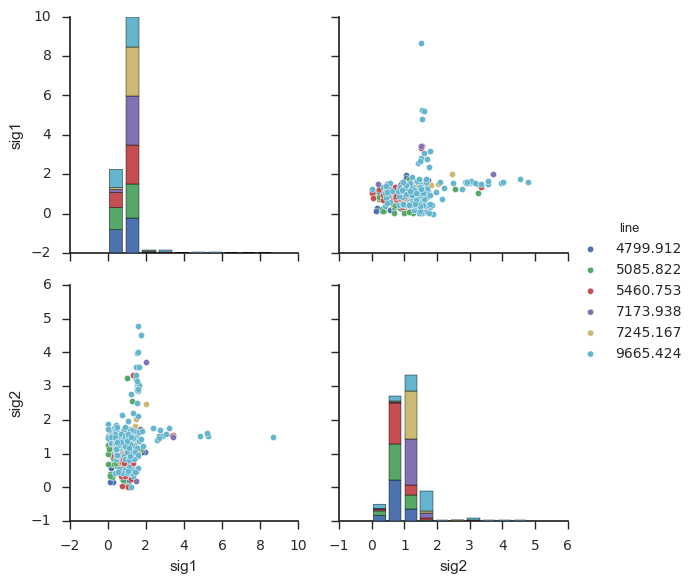

In [59]:
print("Sig 1: %.3f(%.3f)"%(np.mean(df1['sig1']), np.std(df1['sig1'])))
print("Sig 2: %.3f(%.3f)"%(np.mean(df1['sig2']), np.std(df1['sig2'])))
sns.pairplot(df1, vars = ['sig1','sig2'],hue='line',size = 3)

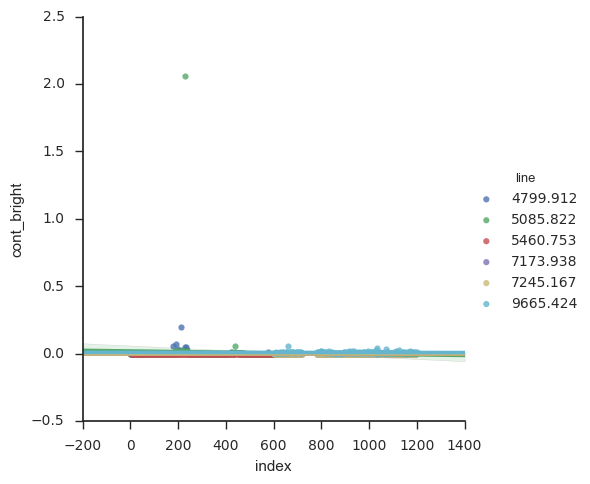

In [64]:
df1['cont_bright'] = df1['c']/df1['total_flux']
sns.lmplot(data = df1.reset_index(), x = 'index', y = 'cont_bright', hue = 'line')

I think it's best to fix one of the gaussian to be above and one below: 

In [69]:
def run_model_2(line, file, fiber_num, color):
    flux, wave, weights = window_arclines(file, fiber_num, line, 50)
    if color == 'blue':
        N = 83200
    elif color == 'red':
        N = 64000
        
    mod = Model(my_profile)
    params = mod.make_params()
    
    params.add('amp1', value = 1000, min = 0, vary=True)
    params.add('delta', value = 1000, min = 0, vary=True)
    params.add('amp2', expr = 'amp1 - delta')
    params.add('center', value = line, vary = True)
    params.add('wave1', value = line+1.2, min = line-2,max = line+2, vary=True)
    params.add('wave2', value = line-0.5, min = line-2,max = line+2,vary=True)
    params.add('a', value = 10, min = 0)
    params.add('N', value = N, vary = False)
    params.add('sig1', value = 1, min = 0)
    params.add('sig2', value = 1, min = 0)
    params.add('c', value = 10, min = 0)

    model = mod.fit(flux, params, x = wave, weights=weights)
    total_flux = np.sum(model.best_fit)
    return model, total_flux, line

In [70]:
blue_fit_stats2 = []
for blue_file in np.random.choice(blue_arc_files,10):
    for fiber_num in np.random.randint(0, 500, 20):
        for i in [3,5,7]:
            l = my_blue_lines[i]
            mod,  tf, line = run_model_2(l, blue_file, fiber_num,'blue')
            blue_fit_stats2.append(collect_params(mod, tf, line))

/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.


In [71]:
red_fit_stats2 = []
for blue_file in np.random.choice(red_arc_files,10):
    for fiber_num in np.random.randint(0, 500, 20):
        for i in [11,12,21]:
            l = my_red_lines[i]
            mod,  tf, line = run_model_2(l, blue_file, fiber_num,'red')
            red_fit_stats2.append(collect_params(mod, tf, line))

/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.


In [74]:
fit_stats2 = np.vstack([blue_fit_stats2, red_fit_stats2])

In [75]:
new_params = ['chi2','total_flux','line']
df2 = pd.DataFrame(fit_stats, columns = new_params+list_of_params)
df2.head()

,chi2,total_flux,line,amp1,amp2,center,wave1,wave2,a,N,sig1,sig2,c
0,1.858541,89551.784363,4799.912,4451.595428,5624.836937,4800.385092,4797.970383,4799.397634,163.515905,83200.0,0.874322,0.943774,4.392821
1,3.466918,140636.760256,5085.822,15885.324587,12524.453863,5085.762973,5086.441428,5084.988978,87.959518,83200.0,1.002395,0.936002,8.732216
2,3.810077,642640.296573,5460.753,5558.628905,19783.150035,5460.422857,5459.211395,5461.049643,452.338431,83200.0,0.727720,1.163500,1.054080
3,1.567369,90211.558140,4799.912,6083.643626,3422.468936,4799.917179,4800.363994,4798.915614,208.183916,83200.0,1.006188,0.822392,3.875356
4,3.997972,142261.601665,5085.822,10615.622710,8634.691502,5086.236390,5085.339817,5083.860387,159.056596,83200.0,0.944072,0.844362,4.933910


In [76]:
df2 = df2[df2['chi2']<10]

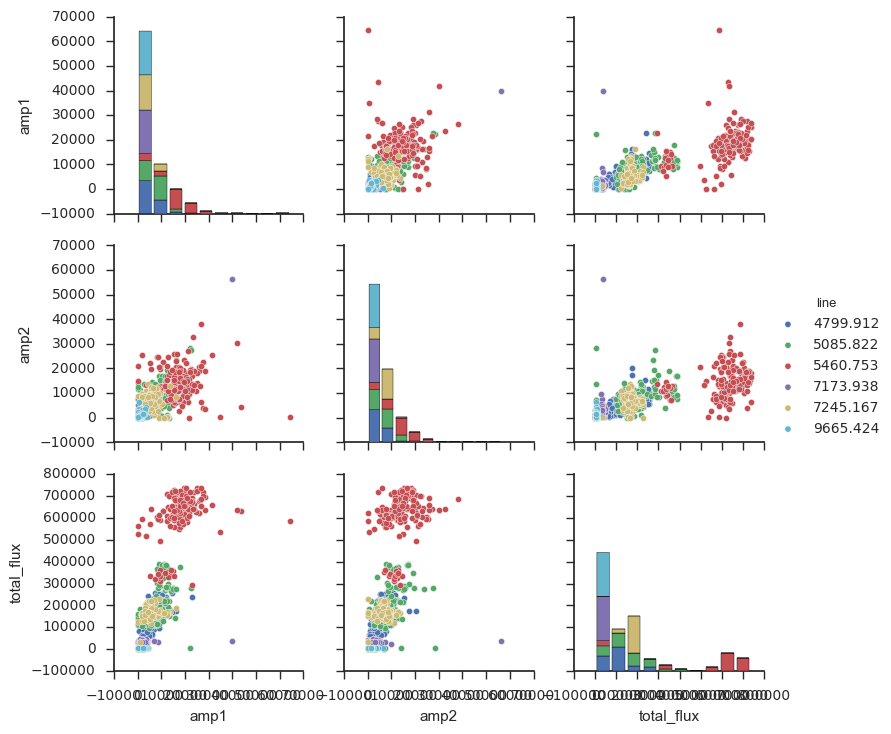

In [77]:
sns.pairplot(df2, vars = ['amp1','amp2','total_flux'],hue='line')

Diff 1: 0.20 (1.08)
Diff 2:-0.95 (0.91) 


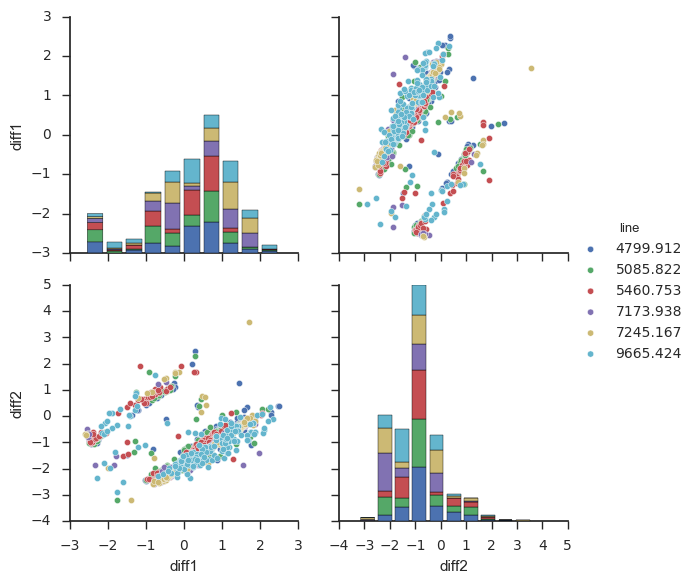

In [79]:
df2['diff1'] = df2['wave1'] - df2['center'] 
df2['diff2'] = df2['wave2'] - df2['center'] 
print("Diff 1: %.2f (%.2f)"%(np.mean(df2['diff1']),np.std(df2['diff1'])))
print("Diff 2:%.2f (%.2f) "%(np.mean(df2['diff2']),np.std(df2['diff2'])))
sns.pairplot(df2, vars = ['diff1','diff2'],size = 3,hue = 'line')

Doesn't seem to make much of a difference at all.

How flexible are the parameters though? We saw already that there is some play in the amplitude and N effective of the scattering function, but what about the parameters for the core?

In [82]:
arc_line = my_blue_lines[7]
bfile = blue_arc_files[15]
flux, wave, weights = window_arclines(bfile, 205, arc_line, 40)

xx = np.linspace(min(wave)+30,max(wave)-30,((max(wave)+30)-(min(wave)-30))*10)
f = interp1d(wave, flux, bounds_error=False, fill_value=0)
new_flux = f(xx)
total_flux = np.sum(new_flux)

/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.
/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


6.16567655147


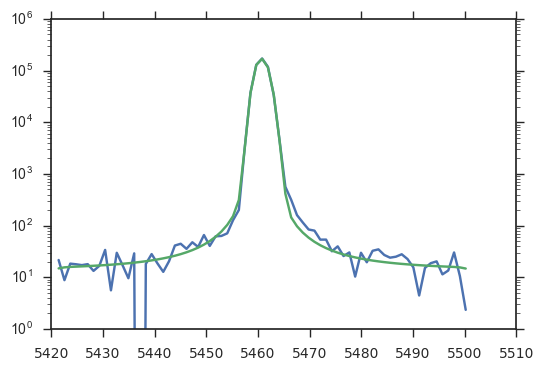

In [83]:
mod = Model(my_profile)
params = mod.make_params()
params.add('amp1', value = 1000, min = 0)
params.add('amp2', value = 1000, min = 0)
params.add('center', value = arc_line, vary = True)
params.add('wave1', value = arc_line)
params.add('wave2', value = arc_line)
params.add('a', value = 1000, min = 0)
params.add('N', value = 83200, vary = False)
params.add('sig1', value = 1, min = 0)
params.add('sig2', value = 1, min = 0)
params.add('c', value = 10, min = 0)

pre_model = mod.fit(flux, params, x = wave, weights=weights)
plt.semilogy(wave, flux)
plt.semilogy(wave, pre_model.best_fit)
plt.ylim(pow(10,0),pow(10,6))
print(pre_model.redchi)

In [86]:
#How much does location of the wave1 and wave2 matter?
ff = []
for x in np.linspace(arc_line-1.5, arc_line+1.5,50):
    for y in np.linspace(arc_line-1.5, arc_line+1.5,50):
        mod = Model(my_profile)
        params = mod.make_params()

        params.add('amp1', value = 10000, min = 0, vary=True)
        params.add('delta', value = 1000, min = 0, vary=True)
        params.add('amp2', expr = 'amp1 - delta')
        params.add('center', value = arc_line, vary = True)
        params.add('wave1', value = x, vary=False)
        params.add('wave2', value = y, vary=False)
        params.add('a', value = 10, min = 0)
        params.add('N', value = 83200, vary = False)
        params.add('sig1', value = 1, min = 0)
        params.add('sig2', value = 1, min = 0)
        params.add('c', value = 10, min = 0)

        model = mod.fit(flux, params, x = wave, weights=weights)
        ff.append([pre_model.params['center'],x,y, model.redchi])

KeyboardInterrupt: 

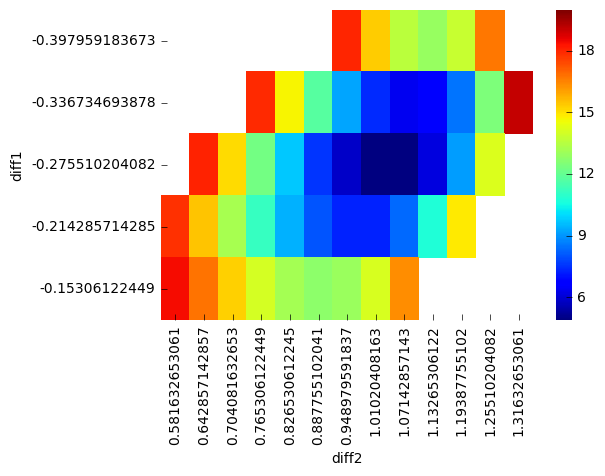

In [37]:
df = pd.DataFrame(ff,columns = ['center','wave1','wave2','chi2'])
#df = df[df['chi2']<20]
df['diff1'] = df['center'] - df['wave1']
df['diff2'] = df['center'] - df['wave2']

mp = df.pivot("diff1","diff2","chi2")
sns.heatmap(data = mp,cmap="jet")

In [41]:
ff = []
for x in np.linspace(200000,600000,50):
    for y in np.linspace(10000,200000,50):
        mod = Model(my_profile)
        params = mod.make_params()

        params.add('amp1', value = x, vary=False)
        params.add('amp2', value = y, vary=False)
        params.add('center', value = pre_model.params['center'], vary=False)
        params.add('wave1', value = pre_model.params['wave1'], vary=False)
        params.add('wave2', value = pre_model.params['wave2'], vary=False)
        params.add('a', value = pre_model.params['a'], vary=False)
        params.add('N', value = 500, vary=False)
        params.add('sig1', value = pre_model.params['sig1'], vary=False)
        params.add('sig2', value = pre_model.params['sig2'], vary=False)
        params.add('c', value = pre_model.params['c'], vary=False)

        model = mod.fit(flux, params, x = wave, weights=weights)
        ff.append([x,y, model.redchi])

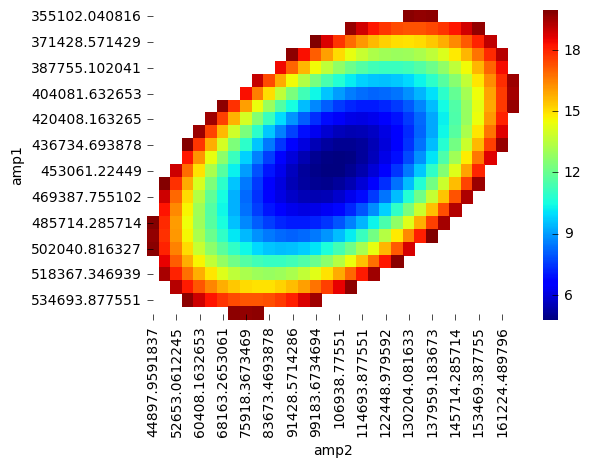

In [42]:
df = pd.DataFrame(ff,columns = ['amp1','amp2','chi2'])
df = df[df['chi2']<20]

mp = df.pivot("amp1",'amp2',"chi2")
sns.heatmap(data = mp,cmap="jet",vmax=20)

In [44]:
ff = []
for x in np.linspace(0.1,2,50):
    for y in np.linspace(0.1,2,50):
        mod = Model(my_profile)
        params = mod.make_params()

        params.add('amp1', value = pre_model.params['amp1'], vary=False)
        params.add('amp2', value = pre_model.params['amp2'], vary=False)
        params.add('center', value = pre_model.params['center'], vary=False)
        params.add('wave1', value = pre_model.params['wave1'], vary=False)
        params.add('wave2', value = pre_model.params['wave2'], vary=False)
        params.add('a', value = pre_model.params['a'], vary=False)
        params.add('N', value = 500, vary=False)
        params.add('sig1', value = x, vary=False)
        params.add('sig2', value = y, vary=False)
        params.add('c', value = pre_model.params['c'], vary=False)

        model = mod.fit(flux, params, x = wave, weights=weights)
        ff.append([x,y, model.redchi])

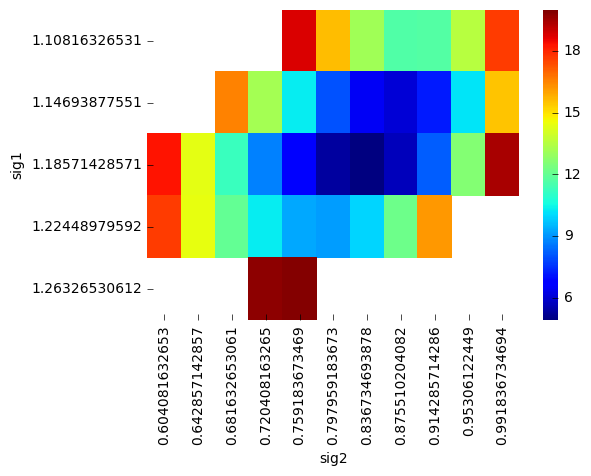

In [45]:
df = pd.DataFrame(ff,columns = ['sig1','sig2','chi2'])
df = df[df['chi2']<20]

mp = df.pivot("sig1",'sig2',"chi2")
sns.heatmap(data = mp,cmap="jet",vmax=20)

## Try to fit all the lines

Let's first try creating a linear model using a simplified model made from fitting the biggest line. See how close I can get.

In [131]:
def my_line_model(x, A, B, C,D, center):
    sig = 1
    N = 83200
    gauss1 = np.exp(-(x-(center+0.6))**2/(2*sig**2.))
    gauss2 = np.exp(-(x-(center-0.9))**2/(2*sig**2.)) 
    core = A*(gauss1 + gauss2) 
    
    w = center/N * (1/(np.sqrt(2)*np.pi))
    top = w**2.
    bot = ((x-center)**2+w**2)
    scatt = B*top/bot 
    
    return np.convolve(core, scatt, 'same')

In [132]:
arc_line = my_blue_lines[7]
bfile = blue_arc_files[15]
flux, wave, weights = window_arclines(bfile, 205, arc_line, 40)
mod = Model(my_line_model)
params = mod.make_params()

params.add('center', value = arc_line, vary=False)
params.add('A', value = .1, vary=True)
params.add('B', value = .1, vary=True)
params.add('C', value = .1, vary=True)
params.add('D', value = 1000, vary=True)

model = mod.fit(flux, params, x = wave, weights=weights)
model.params.pretty_print()
print(model.redchi)

/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.


Name       Value      Min      Max   Stderr     Vary     Expr Brute_Step
A           1687     -inf      inf        0     True     None     None
B           1161     -inf      inf        0     True     None     None
C          144.3     -inf      inf        0     True     None     None
D           1000     -inf      inf        0     True     None     None
center      5461     -inf      inf        0    False     None     None
84.4034045394


In [133]:
def line_model(x, center):
    sig = 1
    N = 83200
    gauss1 = np.exp(-(x-(center+0.6))**2/(2*sig**2.))
    gauss2 = np.exp(-(x-(center-0.9))**2/(2*sig**2.)) 
    core = (gauss1 + gauss2) 
    
    w = center/N * (1/(np.sqrt(2)*np.pi))
    top = w**2.
    bot = ((x-center)**2+w**2)
    scatt = top/bot 
    
    return np.convolve(core, scatt, 'same')

In [140]:
def scatter_profile(x,amplitude, center, N_eff):
    w = center/N_eff * (1/(np.sqrt(2)*np.pi))
    top = w**2.
    bot = ((x-center)**2+w**2)
    l = amplitude*top/bot 
    return l
def line_model(wave, line, sigmas):
    one =np.exp(-0.5*((wave - (line+0.5))/sigmas)**2)
    two = .5*np.exp(-0.5*((wave - (line-0.9))/sigmas)**2)
    three = (.007)*scatter_profile(wave, 1, line, 500)
    model = one+two+three
    return model

In [141]:
flux, sigmas, wave, all_arc_lines = extract_data(bfile, 205)
weights = error_model(flux)


AA = []
AB = []
for line in all_arc_lines:
    AA.append(line_model(wave, line,sigmas))
    AB.append(np.exp(-0.5*((wave-line)/sigmas)**2))
AA = np.vstack(AA)
AB = np.vstack(AB)

AC = []
for i in range(2):
    AC.append(eval_legendre(i, wave))
AC = np.array(AC)
A = np.stack( np.vstack((AC,AA)), axis=1)
B = np.stack(np.vstack((AC,AB)), axis=1)

/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.


In [142]:
results1 = sm.WLS(flux, A, weights = weights).fit()
params1 = results1.params
model1 = np.dot(A, params1)
results2 = sm.WLS(flux, B, weights = weights).fit()
params2 = results2.params
model2 = np.dot(B, params2)

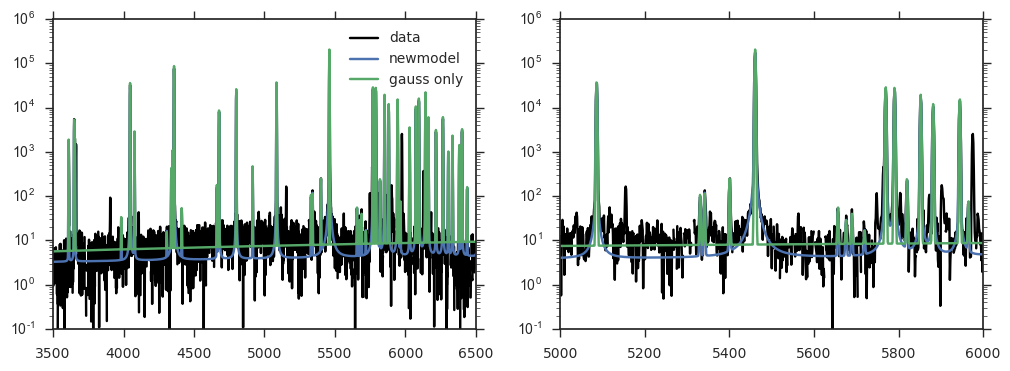

In [145]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.semilogy(wave, flux,'k', label = 'data')
ax1.semilogy(wave, model1,label = 'newmodel')
ax1.semilogy(wave, model2, label = 'gauss only')
ax2.semilogy(wave, flux, 'k',label = 'data')
ax2.semilogy(wave, model1,label = 'newmodel')
#plt.semilogy(wave, flux - model1, label = 'residuals')
ax2.semilogy(wave, model2, label = 'gauss only')
ax1.set_xlim(3500,6500)
ax1.set_ylim(pow(10,-1),pow(10,6))
ax2.set_xlim(5000,6000)
ax2.set_ylim(pow(10,-1),pow(10,6))
ax1.legend()

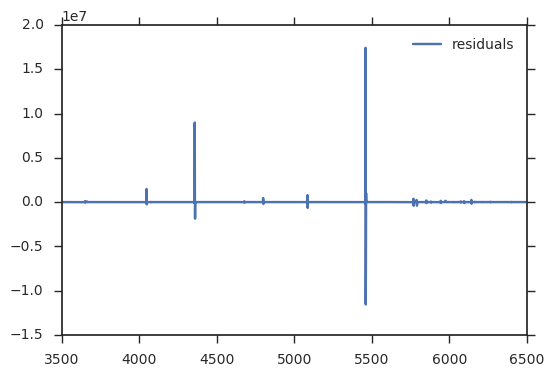

In [149]:
plt.figure()
plt.plot(wave, (flux - model1)/error_model(flux), label = 'residuals')
plt.xlim(3500,6500)
#plt.ylim(pow(10,-1),pow(10,6))
plt.legend()

In [150]:
flux, sigmas, wave, all_arc_lines = extract_data(rfile, 10)
weights = error_model(flux)

AA = []
AB = []
for line in all_arc_lines:
    AA.append(line_model(wave, line, sigmas))
    AB.append(np.exp(-0.5*((wave-line)/sigmas)**2))
AA = np.vstack(AA)
AB = np.vstack(AB)

AC = []
for i in range(1):
    AC.append(eval_legendre(i, wave))
AC = np.array(AC)
A = np.stack( np.vstack((AC,AA)), axis=1)

/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.


In [151]:
results1 = sm.WLS(flux, A, weights = weights).fit()
params1 = results1.params
model1 = np.dot(A, params1)

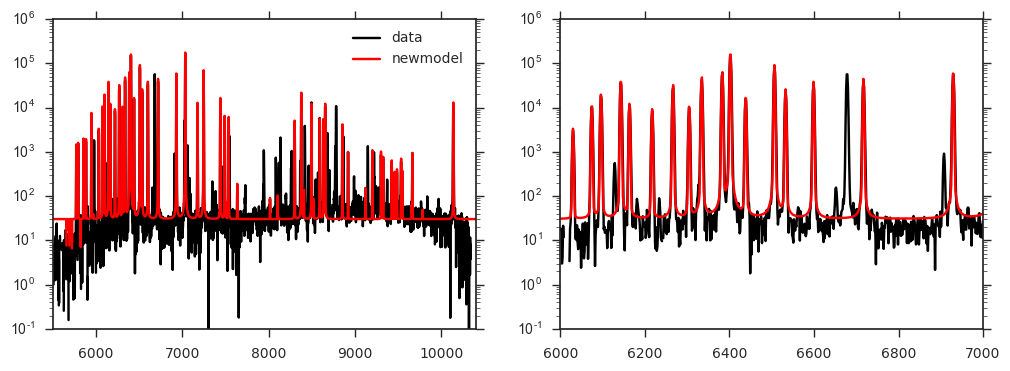

In [152]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.semilogy(wave, flux, 'k-',label = 'data')
ax1.semilogy(wave, model1,'r-',label = 'newmodel')
ax2.semilogy(wave, flux, 'k-',label = 'data')
ax2.semilogy(wave, model1,'r-',label = 'newmodel')
#plt.semilogy(wave, flux - model1, label = 'residuals')
#plt.semilogy(wave, model2, label = 'oldmodel')
ax1.set_xlim(5500,10400)
ax1.set_ylim(pow(10,-1),pow(10,6))
ax2.set_xlim(6000,7000)
ax2.set_ylim(pow(10,-1),pow(10,6))
ax1.legend()

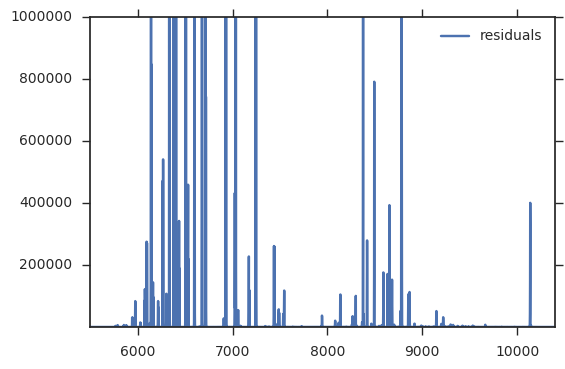

In [154]:
plt.figure()
plt.plot(wave, (flux - model1)/error_model(flux), label = 'residuals')
plt.xlim(5500,10400)
plt.ylim(pow(10,-1),pow(10,6))
plt.legend()

That's not going to work, so let's use a non-linear fitter

/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.


[ 5400.5616  5460.753 ]


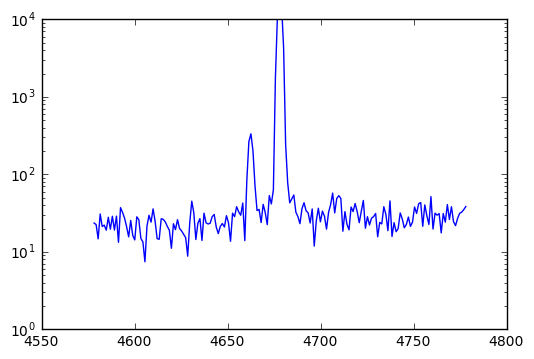

In [203]:
arc_line = my_blue_lines[2]
my_lines = my_blue_lines[6:8]
bfile = np.random.choice(blue_arc_files,1)[0]
flux, wave, weights = window_arclines(bfile, 205, arc_line, window_size = 100)
plt.semilogy(wave, flux)
plt.ylim(pow(10,0),pow(10,4))
print(my_lines)
#plt.xlim(4650,4670)

In [342]:
def scatter_profile(x,amplitude, center, N_eff):
    w = center/N_eff * (1/(np.sqrt(2)*np.pi))
    top = w**2.
    bot = ((x-center)**2+w**2)
    l = amplitude*top/bot 
    return l

In [343]:
def my_profile(x, amp1,amp2, a, center, wave1, wave2, sig1, sig2):
    N = 325
    gauss1 = amp1*np.exp(-(x-wave1)**2/(2*sig1**2.))
    gauss2 = amp2*np.exp(-(x-wave2)**2/(2*sig2**2.)) 
    core = gauss1 +gauss2
    
    scatt = scatter_profile(x, a, center, N)
    
    return core + scatt

In [352]:
def make_model(letter, line):
    pref = 'f%s_' % str(letter)
    model = Model(my_profile, prefix = pref)
    model.set_param_hint(pref+'amp1', value = 100, min = 0)
    model.set_param_hint(pref+'amp2', value = 100, min = 0)
    model.set_param_hint(pref+'center', value = line, min = line-1, max = line + 1,vary = True)
    model.set_param_hint(pref+'wave1', value = line+0.6, min = line-2,max = line+2, vary=True)
    model.set_param_hint(pref+'wave2', value = line-0.9, min = line-2,max = line+2,vary=True)
    model.set_param_hint(pref+'a', value = 100, min = 0)
    model.set_param_hint(pref+'sig1', value = 1, min = 0,max = 2)
    model.set_param_hint(pref+'sig2', value = 1, min = 0, max = 2)

    return model

In [377]:
flux, sigmas, wave, all_arc_lines = extract_data(bfile, 10)
weights = error_model(flux)

mod = None
for i, line in enumerate(all_arc_lines):
    this_mod = make_model(i, line)
    if mod is None:
        mod = this_mod
    else:
        mod = mod + this_mod

offset = ConstantModel()
offset.set_param_hint('c', value = 1)
#offset.set_param_hint('m', value = 1)
mod = mod + offset
params = mod.make_params()

/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.


In [285]:
wave

array([ 2847.95560697,  2848.81651829,  2849.67762261, ...,  7218.14020715,
        7219.2561787 ,  7220.37212213])

In [378]:
out = mod.fit(flux, params, x= wave, weights = weights)

In [379]:
init = mod.eval(params, x=wave)

In [393]:
comps = out.eval_components()

In [394]:
comps.keys()

odict_keys(['f0_', 'f1_', 'f2_', 'f3_', 'f4_', 'f5_', 'f6_', 'f7_', 'f8_', 'f9_', 'f10_', 'f11_', 'f12_', 'f13_', 'f14_', 'f15_', 'f16_', 'f17_', 'f18_', 'f19_', 'f20_', 'f21_', 'f22_', 'f23_', 'f24_', 'f25_', 'f26_', 'f27_', 'f28_', 'f29_', 'f30_', 'f31_', 'f32_', 'f33_', 'f34_', 'f35_', 'f36_', 'f37_', 'f38_', 'f39_', 'f40_', 'f41_', 'f42_', 'f43_', 'f44_', 'constant'])

In [398]:
comps['constant']

3.6511419017034834

(0, 80000)

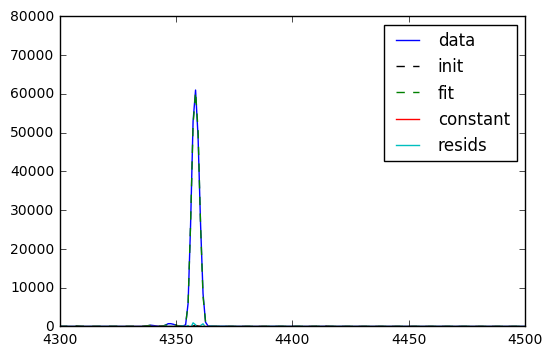

In [422]:
plt.plot(wave, flux, label = 'data')
plt.plot(wave, init, 'k--', label = 'init')
plt.plot(wave, out.best_fit, '--',label = 'fit')
plt.plot(wave, np.ones(len(wave))*comps['constant'], label = 'constant')
plt.plot(wave, (flux - out.best_fit)+comps['constant'], label = 'resids')
plt.legend()
plt.xlim(4300, 4500)
#plt.ylim(pow(10,-2), pow(10,6))
plt.ylim(0,80000)

(3500, 6500)

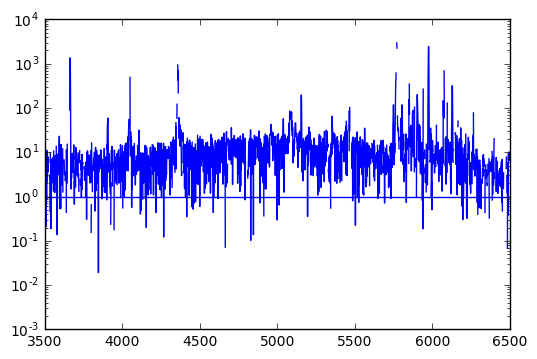

In [424]:
plt.semilogy(wave, (flux - out.best_fit)+ comps['constant'])
plt.axhline(1)
plt.xlim(3500, 6500)